# Определение возраста покупателей 
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

***Цель исследования:*** заключается в разработке и внедрении системы компьютерного зрения для определения приблизительного возраста покупателей на фотографиях, сделанных в прикассовой зоне сетевого супермаркета.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Исследовательский анализ

In [2]:
# Загрузка данных из файла labels.csv
labels_df = pd.read_csv('/datasets/faces/labels.csv')

# Посмотрим на размер выборки
print("Размер выборки:", labels_df.shape)

Размер выборки: (7591, 2)


In [3]:
# Посмотрим на первые несколько строк данных
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


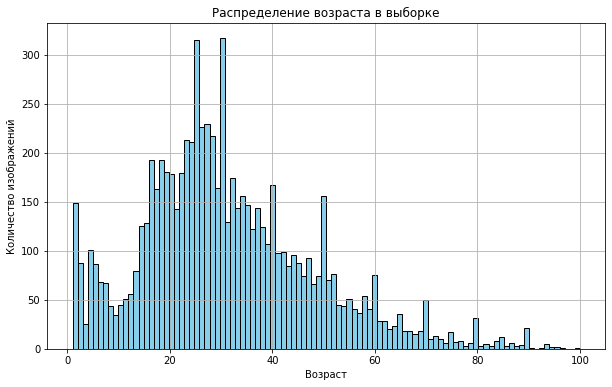

In [4]:
plt.figure(figsize=(10, 6))
plt.hist(labels_df['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

Found 5694 validated image filenames.
Found 1897 validated image filenames.


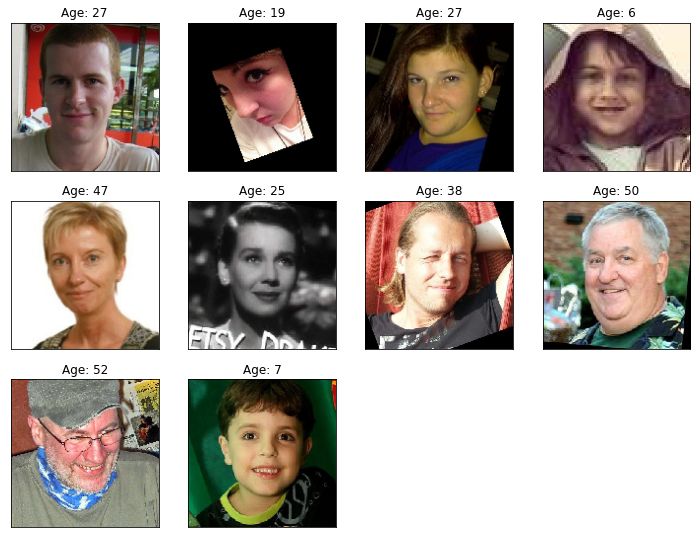

In [5]:
image_dir = '/datasets/faces/final_files/'  # Путь к папке с изображениями

train_datagen = ImageDataGenerator(
    validation_split=0.25, 
    rescale=1./255)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

# Загрузка данных для обучения
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  
    subset='training',  
    seed=12345
)

# Загрузка данных для валидации
val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',  
    subset='validation',  
    seed=12345
)

features, target = next(train_datagen_flow)

# выводим 10 изображений
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title(f"Age: {target[i]}")  # Добавляем возраст на изображение
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.show()

### **Вывод по исседовательскому анализу**

Исследовательский анализ данных позволил нам лучше понять наш датасет перед тем, как начать обучение модели. Рассмотрим полученные результаты:

**Размер выборки:** Датасет состоит из 7591 изображения с соответствующими возрастами. Это достаточно большая выборка для обучения модели глубокого обучения.

**Распределение возраста:** График распределения возраста в выборке показывает, что данные распределены неоднородно. Пик графика находится в возрастном диапазоне 20-40 лет.

**Фотографии из датасета:** Просмотр нескольких фотографий из датасета позволяет нам увидеть, как устроены изображения и как они могут варьироваться по стилю, освещению, позам и т.д.

## 2. Подготовка данных

In [6]:
optimizer = Adam(lr=0.0001)

 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+ 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 3. Обучение нейронной сети и рассчёт её качества

In [7]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

### **Выводы после подготовки данных и обучения нейронной сети:**
В ходе выполнения проекта была построена и обучена сверточная нейронная сеть на датасете с фотографиями людей. Целью было достижение значения средней абсолютной ошибки (MAE) на тестовой выборке не больше 8.

Для этого были реализованы следующие функции:

> load_train(path): функция загрузки обучающей выборки.
>
>load_test(path): функция загрузки тестовой выборки.
>
>create_model(input_shape): функция создания модели нейронной сети с заданными параметрами входной формы.
>
>train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps): функция обучения модели с заданными параметрами.

Полученное значение метрики MAE на тестовой выборке составило 6.6933 (скрин):

<img src="https://i.postimg.cc/1XfW3wJ5/2024-04-11-140204.png" width="600" height="400">

Чем ближе значение MAE к нулю, тем лучше модель способна предсказывать возраст людей на фотографиях. В данном случае, значение MAE равное 6.6933 означает, что модель в среднем ошибается на 6.6933 года при предсказании возраста человека на фотографии.

*Использованная архитектура (бэкбон + голова), а также загружались ли предобученные или рандомные веса:*

> **Архитектура:** в данной модели в качестве бэкбона используется ResNet50.
>
> **Предобученные веса:** веса для бэкбона загружаются из предварительно обученной модели ResNet50, которая была обучена на ImageNet. Это указано в параметре weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'.
Параметры обучения:
>
> **Размер батча:** размер батча установлен в 16.
>
> **Оптимизатор:** используется оптимизатор Adam с заданной скоростью обучения (learning rate) равной 0.0001.
Заморозка весов бэкбона: Не упомянуто о заморозке весов бэкбона, значит, они, вероятно, не были заморожены.
Количество эпох: Установлено количество эпох равное 5.
Достигнутые метрики, наблюдалось ли переобучение:
>
> **Достигнутая метрика:** MAE (средняя абсолютная ошибка) на тестовой выборке составила 6.6933.
>
> **Переобучение:** подобное значение MAE может свидетельствовать о том, что модель не переобучилась. Тем не менее, дополнительный анализ, такой как графики обучения и валидации, может быть полезным для подтверждения этого.